Разведочный анализ датасета изображений рентгеновских снимков
Цели ноутбука:

Провести анализ характеристик изображений
Провести анализ метаданных изображений
Провести визуальный анализ изображений
Визуализировать данные
Провести первичную предобработку
Сделать выводы по структуре данных
Для разведочного анализа используется подготовленный датасет, состоящий из рентген-снимков

##Импорт библиотек

In [1]:
import zipfile
import os
import shutil
import random
import hashlib
import seaborn as sns
import os
import cv2

import gdown

from tqdm.auto import tqdm

from PIL import Image, ExifTags, ImageOps, ImageChops, ImageEnhance
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import numpy as np

from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split, ConcatDataset
import torch.nn.functional as F
import random

# Импорт необходимых библиотек
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


In [2]:
from data_utils import setup_environment, download_and_extract, print_directory_structure, analyze_dataset
from data_cleaner import find_duplicates, visualize_duplicates, clean_dataset, copy_test_folder

## Загрузка файлов

In [3]:
# 1. Настройка окружения
DRIVE_DIR, DATASET_DIR, ZIP_PATH = setup_environment()

# 2. Загрузка данных
FILE_ID = "1ltYQh_bwNuJJ1nr91w3hZlGcnxrFOyF6"
download_and_extract(FILE_ID, ZIP_PATH, DATASET_DIR)

# 3. Очистка данных
CLASSES = ['NORMAL', 'PNEUMONIA']
TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray/train")
CLEAN_TRAIN_DIR = os.path.join(DATASET_DIR, "chest_xray_clean/train")

Mounted at /content/drive
Данные распакованы в: /content/dataset


In [ ]:
import tarfile

# Пути к данным
DATASET_DIR_OCT = os.path.join(os.getcwd(), "dataset_oct")
ZIP_PATH_OCT = os.path.join(DRIVE_DIR, "OCT2017.tar.gz")

# Создание папки для датасета, если её нет
os.makedirs(DATASET_DIR_OCT, exist_ok=True)

# ID файла на Google Drive
file_id = "1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN"

# Загрузка архива, если он ещё не загружен
if os.path.exists(ZIP_PATH_OCT):
    print("Архив уже добавлен")
else:
    gdown.download(
        f"https://drive.google.com/uc?id={file_id}",
        ZIP_PATH_OCT,  # Исправлено на использование ZIP_PATH
        quiet=False,
    )

# Распаковка архива
with tarfile.open(ZIP_PATH_OCT, 'r:gz') as tar_ref:
        tar_ref.extractall(DATASET_DIR_OCT) # Распаковка в папку dataset_oct

# Проверка структуры папок
print(f"Количество папок: {len(os.listdir(DATASET_DIR_OCT))}")


Downloading...
From (original): https://drive.google.com/uc?id=1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN
From (redirected): https://drive.google.com/uc?id=1Rfccuck7bN4HvO4BRr8RRorPcZw5v0AN&confirm=t&uuid=1aa189a3-1826-4524-ad16-967cf535d22b
To: /content/drive/MyDrive/OCT2017.tar.gz
100%|██████████| 5.79G/5.79G [00:57<00:00, 102MB/s]


Количество папок: 1


# EDA

## Анализ дубликатов рентгеновских снимков легких


Класс: NORMAL
Всего пар дубликатов: 1


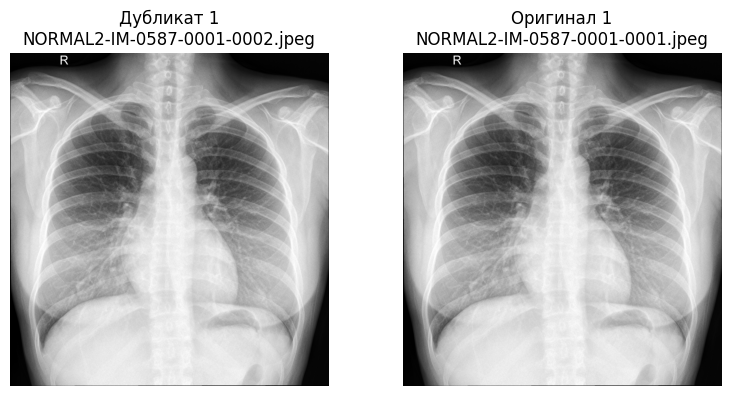


Класс: PNEUMONIA
Всего пар дубликатов: 25


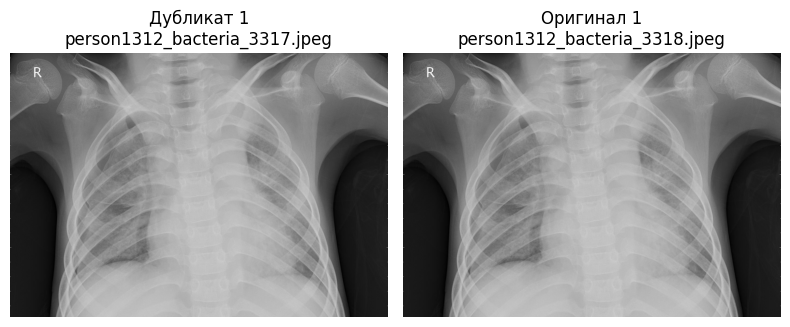

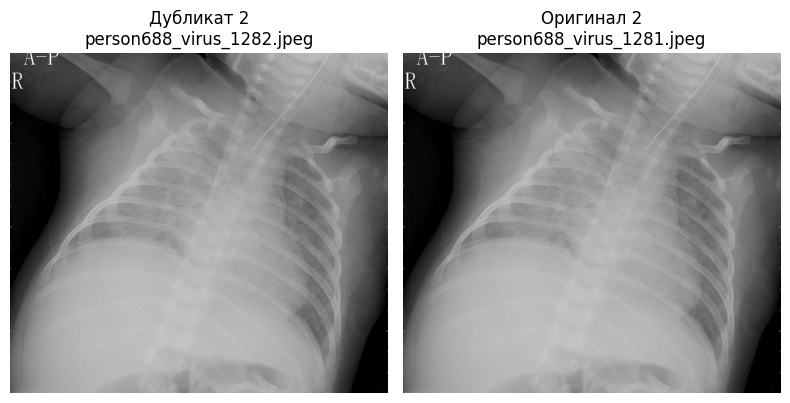

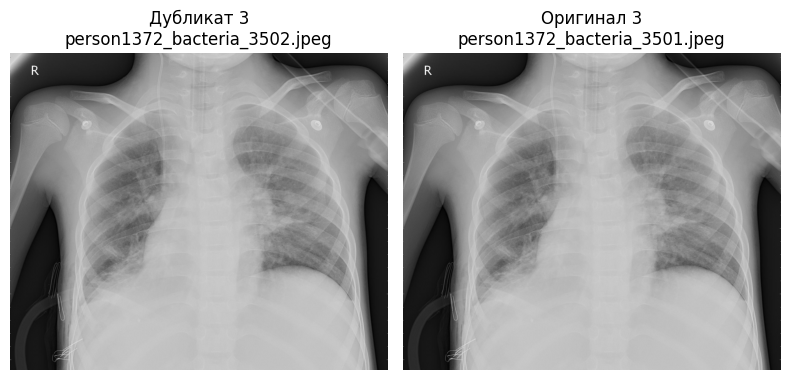

Обработка классов: 100%|██████████| 2/2 [00:01<00:00,  1.18it/s]


Итоги:
Скопировано уникальных файлов: 5206
Пропущено дубликатов: 26
Очищенный датасет сохранен в: /content/dataset/chest_xray_clean/train


In [4]:
# Поиск дубликатов
duplicates_dict = {}
all_duplicates_files = {}

for cls in CLASSES:
    path = os.path.join(TRAIN_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация
if duplicates_dict:
    visualize_duplicates(duplicates_dict)
else:
    print("Дубликаты не найдены")

# Создание чистого датасета
clean_dataset_path = clean_dataset(
    TRAIN_DIR,
    CLEAN_TRAIN_DIR,
    CLASSES,
    all_duplicates_files
)

print(f"Очищенный датасет сохранен в: {clean_dataset_path}")

Обнаружился 1 дубликат в классе Normal и 25 дубликатов в классе PNEUMONIA

In [5]:
src_dir = os.path.join(DATASET_DIR, "chest_xray")
clean_dir = os.path.join(DATASET_DIR, "chest_xray_clean")
copy_test_folder(src_dir, clean_dir)

Папка test скопирована в /content/dataset/chest_xray_clean/test


'/content/dataset/chest_xray_clean/test'

## Анализ дубликатов OCT

Поиск дубликатов: 100%|██████████| 4/4 [00:12<00:00,  3.18s/it]



Класс: CNV
Всего пар дубликатов: 5570


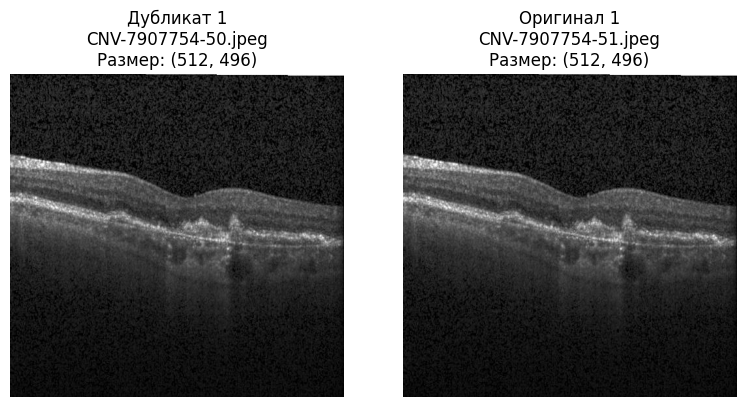

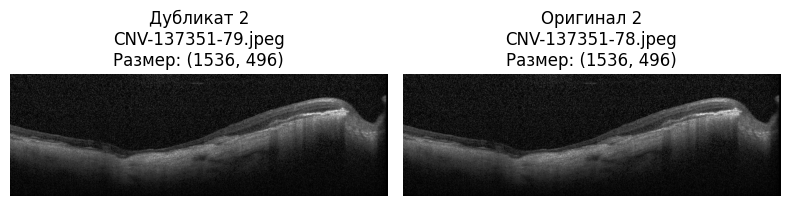

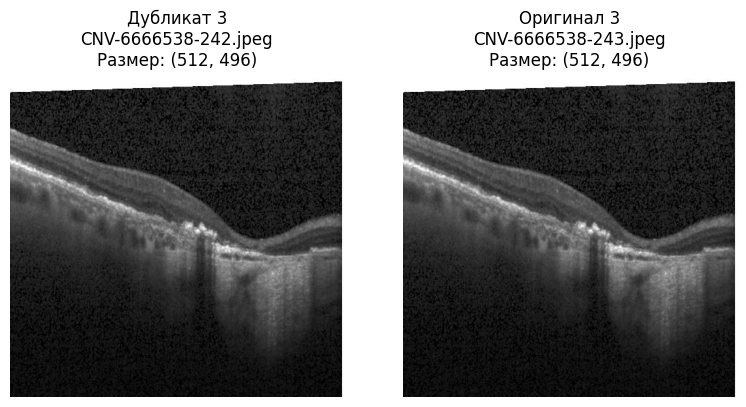


Класс: DME
Всего пар дубликатов: 409


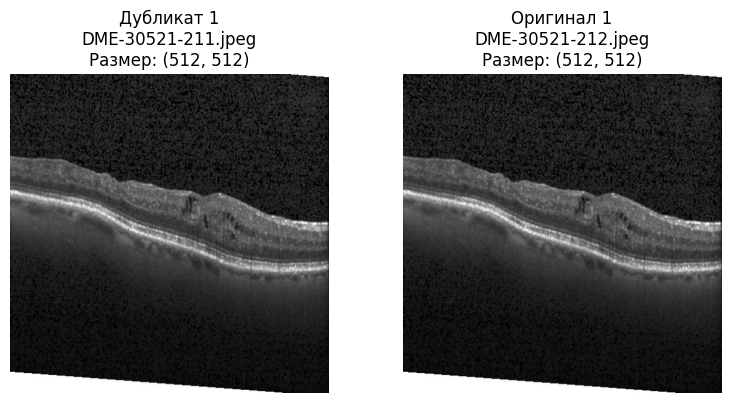

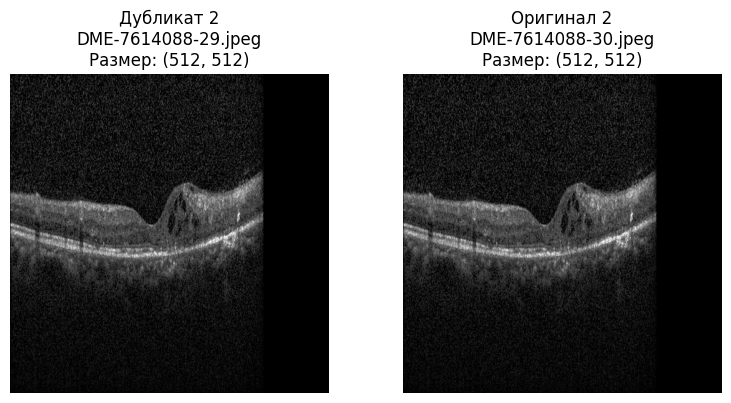

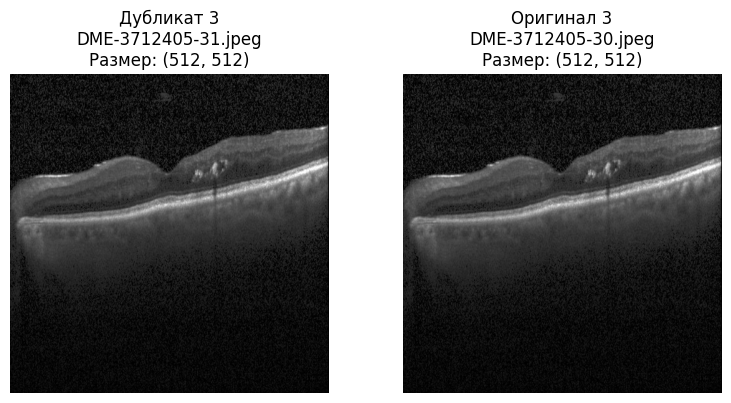


Класс: DRUSEN
Всего пар дубликатов: 599


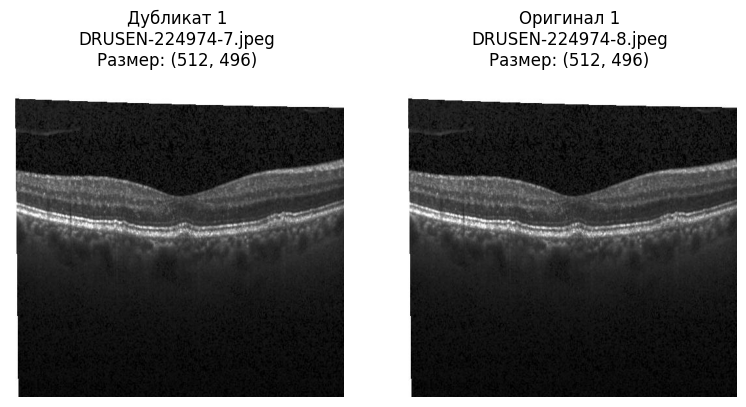

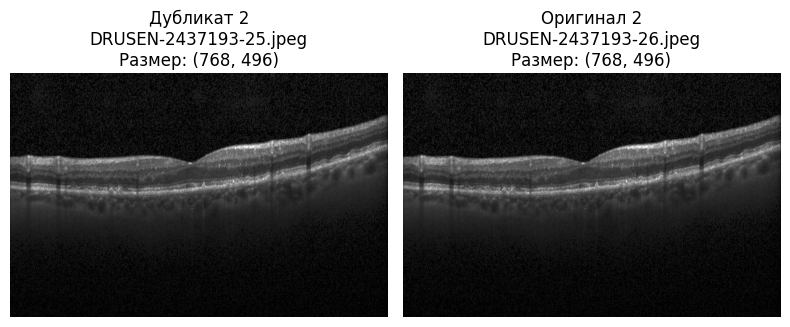

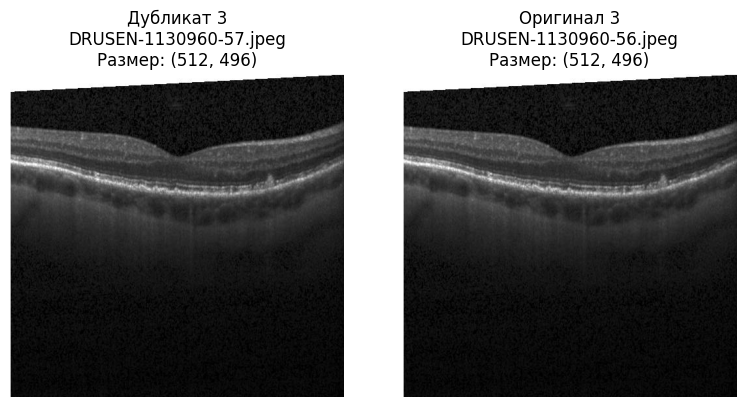


Класс: NORMAL
Всего пар дубликатов: 184


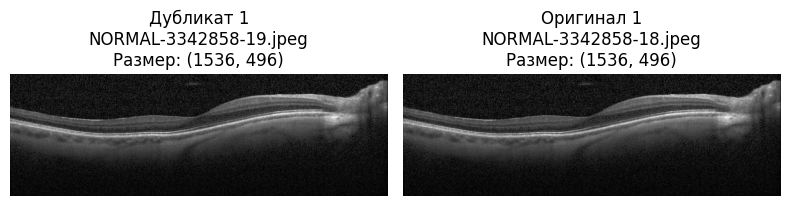

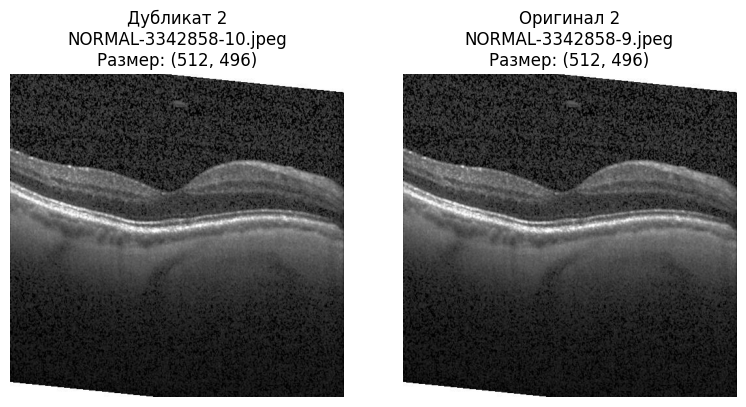

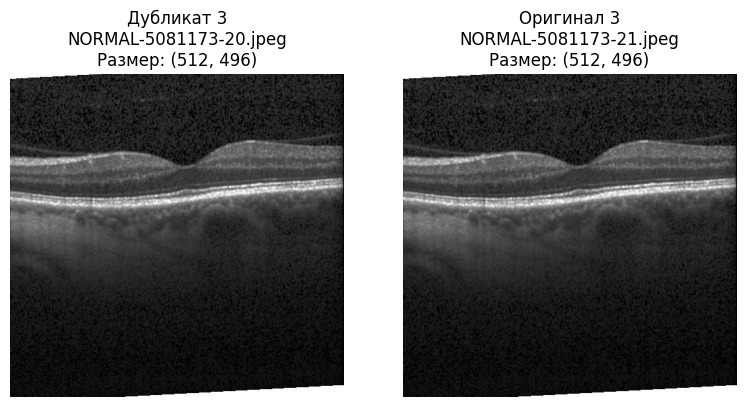


Создание очищенного датасета...


Обработка классов:  25%|██▌       | 1/4 [00:05<00:17,  5.71s/it]


Класс CNV:
  Скопировано уникальных файлов: 31635
  Пропущено дубликатов: 5570


Обработка классов:  50%|█████     | 2/4 [00:07<00:07,  3.50s/it]


Класс DME:
  Скопировано уникальных файлов: 10939
  Пропущено дубликатов: 409


Обработка классов:  75%|███████▌  | 3/4 [00:10<00:03,  3.40s/it]


Класс DRUSEN:
  Скопировано уникальных файлов: 8017
  Пропущено дубликатов: 599


Обработка классов: 100%|██████████| 4/4 [00:15<00:00,  3.89s/it]


Класс NORMAL:
  Скопировано уникальных файлов: 26131
  Пропущено дубликатов: 184

Итоги:
Всего скопировано уникальных файлов: 76722
Всего пропущено дубликатов: 6762

Очищенный датасет сохранен в: dataset_clean/OCT2017/train


In [ ]:
# Пути к папкам
DATASET_DIR = 'dataset_oct/OCT2017/train'
CLEAN_DATASET_DIR = 'dataset_clean/OCT2017/train'  # Папка для очищенного датасета
classes = ['CNV', 'DME', 'DRUSEN', 'NORMAL']

# Словарь для хранения дубликатов по классам
duplicates_dict = {}
# Словарь для хранения всех файлов-дубликатов по классам
all_duplicates_files = {}

# Поиск дубликатов для каждого класса
for cls in tqdm(classes, desc="Поиск дубликатов"):
    path = os.path.join(DATASET_DIR, cls)
    dup_list, dup_files = find_duplicates(path)
    if dup_list:
        duplicates_dict[cls] = dup_list
        all_duplicates_files[cls] = dup_files

# Визуализация дубликатов (если они есть)
if duplicates_dict:
    show_duplicates(duplicates_dict)
else:
    print("\nДубликаты не найдены.")

# Создание очищенного датасета
print("\nСоздание очищенного датасета...")
total_copied = 0
total_skipped = 0

for cls in tqdm(classes, desc="Обработка классов"):
    # Пути к исходной и новой папкам класса
    src_class_dir = os.path.join(DATASET_DIR, cls)
    dst_class_dir = os.path.join(CLEAN_DATASET_DIR, cls)

    # Получаем множество дубликатов для этого класса
    dup_files = all_duplicates_files.get(cls, set())

    # Копируем уникальные файлы
    copied, skipped = copy_unique_files(src_class_dir, dst_class_dir, dup_files)
    total_copied += copied
    total_skipped += skipped

    print(f"\nКласс {cls}:")
    print(f"  Скопировано уникальных файлов: {copied}")
    print(f"  Пропущено дубликатов: {skipped}")

print(f"\nИтоги:")
print(f"Всего скопировано уникальных файлов: {total_copied}")
print(f"Всего пропущено дубликатов: {total_skipped}")
print(f"\nОчищенный датасет сохранен в: {CLEAN_DATASET_DIR}")

#Аугментации

## Вспомогательные функции

In [6]:
# Установка seed для воспроизводимости результатов
seed = 42

# Задаем seed для генераторов псевдослучайных чисел в Python, PyTorch и NumPy
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)

torch.backends.cudnn.deterministic = True  # Делает CuDNN детерминированным
torch.backends.cudnn.benchmark = False     # Отключает авто-тюнинг (может менять поведение)
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'  # Для некоторых версий CUDA
torch.use_deterministic_algorithms(True)

# Создаем генератор случайных чисел PyTorch и задаем ему seed
g = torch.Generator()
g.manual_seed(seed)

# Функция для установки seed в DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Параметры для DataLoader
batch_size = 32
num_workers = 4  # Количество процессов для загрузки данных


## Загрузка датасета рентген

In [7]:
clean_train_dir = 'dataset/chest_xray_clean/train'
test_dir ='dataset/chest_xray/test'

In [9]:
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def show_augmented_samples(data_dir, transform, n_samples=5):
    """
    Показывает оригинальное и аугментированные изображения из датасета

    Параметры:
        data_dir (str): Путь к директории с данными
        transform: Трансформации для аугментации
        n_samples (int): Количество аугментированных версий для показа
    """
    # Выбираем случайный класс
    class_dir = random.choice(os.listdir(data_dir))
    class_path = os.path.join(data_dir, class_dir)

    # Выбираем случайное изображение
    img_name = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, img_name)

    # Загружаем изображение
    try:
        img = Image.open(img_path).convert('L')  # Конвертируем в grayscale
    except Exception as e:
        print(f"Ошибка загрузки изображения {img_path}: {e}")
        return

    # Показываем оригинальное изображение
    print(f"\nOriginal image: {img_path} (Class: {class_dir})")
    plt.figure(figsize=(5,5))
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f'Original Image\nClass: {class_dir}')
    plt.show()

    # Показываем аугментированные версии
    print(f"Augmented versions (n={n_samples}):")
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        aug_img = transform(img)
        plt.subplot(1, n_samples, i+1)
        plt.imshow(aug_img[0], cmap='gray')  # Для тензора [C,H,W]
        plt.axis('off')
        plt.title(f'Aug #{i+1}')
    plt.tight_layout()
    plt.show()


## Аугментация

In [8]:
# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.ToTensor(),  # Преобразование в тензор
])

In [11]:
# Преобразования для тестового набора данных
test_transform_224 = transforms.Compose([
    transforms.Resize((224, 224)),  # Изменение размера до 224x224
    transforms.ToTensor(),  # Преобразование в тензор
])

### Базовая - только Resize

In [9]:
# Преобразования для обучающего набора данных
train_transform_base = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.ToTensor(),  # Преобразование в тензор
])


In [13]:
# Преобразования для обучающего набора данных
train_transform_base_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person1165_virus_1959.jpeg (Class: PNEUMONIA)


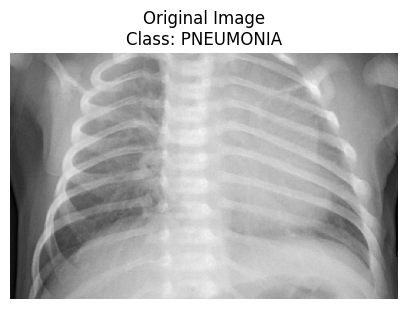

Augmented versions (n=1):


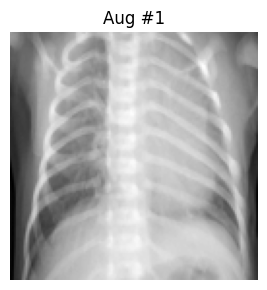

In [ ]:
show_augmented_samples(clean_train_dir, train_transform_base, n_samples=1)

In [10]:
train_data_base = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_base)
test_data = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_base))
train_size = len(train_data_base) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_base, val_data_base = random_split(train_data_base, [train_size, val_size])


In [ ]:
train_data_base_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_base_224)
test_data_224 = datasets.ImageFolder(root=test_dir, transform=test_transform_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_base_224))
train_size = len(train_data_base_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_base_224, val_data_base_224 = random_split(train_data_base_224, [train_size, val_size])


In [11]:
test_loader = DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [ ]:
test_loader_224 = DataLoader(
    test_data_224,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [12]:
train_loader_base =  DataLoader(
    train_data_base,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_base =  DataLoader(
    val_data_base,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [ ]:
train_loader_base_224 =  DataLoader(
    train_data_base_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_base_224 =  DataLoader(
    val_data_base_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - изменения контрастности

In [13]:
# Преобразования для обучающего набора данных
train_transform_color = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),  # Преобразование в тензор
])

In [ ]:
# Преобразования для обучающего набора данных
train_transform_color_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.ColorJitter(brightness=0.1, contrast=0.1),
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person1303_virus_2243.jpeg (Class: PNEUMONIA)


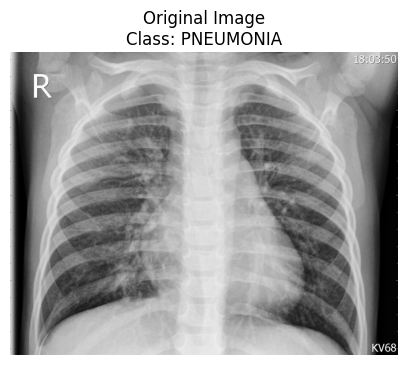

Augmented versions (n=1):


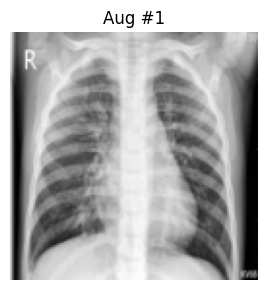

In [ ]:
show_augmented_samples(clean_train_dir, train_transform_color, n_samples=1)

In [14]:
train_data_color = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_color)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_color))
train_size = len(train_data_color) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_color, val_data_color = random_split(train_data_color, [train_size, val_size])


In [ ]:
train_data_color_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_color_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_color_224))
train_size = len(train_data_color_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_color_224, val_data_color_224 = random_split(train_data_color_224, [train_size, val_size])


In [15]:
train_loader_color =  DataLoader(
    train_data_color,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_color =  DataLoader(
    val_data_color,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [ ]:
train_loader_color_224 =  DataLoader(
    train_data_color_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_color_224 =  DataLoader(
    val_data_color_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

### 1 аугментация - сдвиг

In [16]:
# Преобразования для обучающего набора данных
train_transform_affine = transforms.Compose([
            transforms.Resize((128, 128)),  # Изменение размера до 128x128
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # Преобразование в тензор
])

In [21]:
# Преобразования для обучающего набора данных
train_transform_affine_224 = transforms.Compose([
            transforms.Resize((224, 224)),  # Изменение размера до 128x128
            transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
            transforms.ToTensor(),  # Преобразование в тензор
])


Original image: dataset/chest_xray_clean/train/PNEUMONIA/person487_bacteria_2060.jpeg (Class: PNEUMONIA)


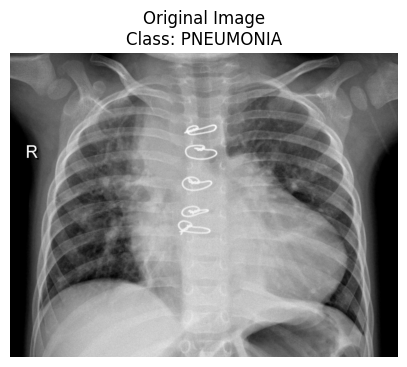

Augmented versions (n=1):


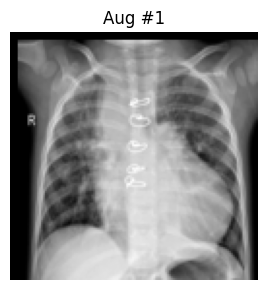

In [ ]:
show_augmented_samples(clean_train_dir, train_transform_affine, n_samples=1)

In [17]:
train_data_affine = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_affine)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_affine))
train_size = len(train_data_affine) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_affine, val_data_affine = random_split(train_data_affine, [train_size, val_size])


In [ ]:
train_data_affine_224 = datasets.ImageFolder(root=clean_train_dir, transform=train_transform_affine_224)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(train_data_affine_224))
train_size = len(train_data_affine_224) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_affine_224, val_data_affine_224 = random_split(train_data_affine_224, [train_size, val_size])


In [18]:
train_loader_affine =  DataLoader(
    train_data_affine,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_affine =  DataLoader(
    val_data_affine,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

In [ ]:
train_loader_affine_224 =  DataLoader(
    train_data_affine_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
val_loader_affine_224 =  DataLoader(
    val_data_affine_224,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

## 3 аугментации base+color+affine

In [19]:
combined_train_data = ConcatDataset([train_data_base, train_data_color, train_data_affine])
combined_val_data = ConcatDataset([val_data_base, val_data_color, val_data_affine])

In [ ]:
combined_train_data_224 = ConcatDataset([train_data_base_224, train_data_color_224, train_data_affine_224])
combined_val_data_224 = ConcatDataset([val_data_base_224, val_data_color_224, val_data_affine_224])

In [20]:
# Создаем DataLoader'ы
train_loader_base_color_affine = DataLoader(
    combined_train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_color_affine = DataLoader(
    combined_val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

In [ ]:
# Создаем DataLoader'ы
train_loader_base_color_affine_224 = DataLoader(
    combined_train_data_224,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

val_loader_base_color_affine_224 = DataLoader(
    combined_val_data_224,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,
)

NameError: name 'combined_train_data_224' is not defined

In [ ]:
print(f"Размер объединенного тренировочного набора: {len(combined_train_data)}")
print(f"Размер объединенного валидационного набора: {len(combined_val_data)}")
print(f"Размер тестового набора: {len(test_data)}")

Размер объединенного тренировочного набора: 12495
Размер объединенного валидационного набора: 3123
Размер тестового набора: 624


# Загрузка датасета OCT

In [ ]:
clean_train_dir_oct = 'dataset_clean/OCT2017/train'
test_dir_oct ='dataset_oct/OCT2017/test'

In [ ]:
# Преобразования для обучающего набора данных
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.RandomHorizontalFlip(),  # Случайное горизонтальное отражение
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Случайное изменение яркости, контраста, насыщенности и оттенка
    transforms.ToTensor(),  # Преобразование в тензор
])

# Преобразования для тестового набора данных
test_transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Изменение размера до 128x128
    transforms.ToTensor(),  # Преобразование в тензор
])

In [ ]:
clean_train_data_oct = datasets.ImageFolder(root=clean_train_dir_oct, transform=train_transform)
test_data_oct = datasets.ImageFolder(root=test_dir_oct, transform=test_transform)

# Размер валидационного набора (например, 20% от обучающего набора)
val_size = int(0.2 * len(clean_train_data_oct))
train_size = len(clean_train_data_oct) - val_size

# Разделение обучающего набора на train_data и val_data
train_data_oct, val_data_oct = random_split(clean_train_data_oct, [train_size, val_size])


In [ ]:
train_loader_oct =  DataLoader(
    clean_train_data_oct,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)
test_loader_oct = DataLoader(
    test_data_oct,
    batch_size=batch_size,
    shuffle=False,  # Для тестовых данных перемешивание не требуется
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

val_loader_oct =  DataLoader(
    val_data_oct,
    batch_size=batch_size,
    shuffle=True,  # Перемешивание данных перед каждой эпохой
    num_workers=num_workers,
    worker_init_fn=seed_worker,
    generator=g,  # Генератор для воспроизводимости
)

# Устройство

In [21]:
# Определение устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Модели для классификации

## Функция для обучения модели

###train_model

In [22]:
import time
from tqdm import tqdm
import numpy as np
import torch

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=5, save_path="best_model.pth"):
    best_accuracy = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Для хранения времени обучения
    total_start_time = time.time()
    epoch_times = []

    for epoch in range(num_epochs):
        print(f"Эпоха {epoch + 1}/{num_epochs}")
        print("-" * 10)

        epoch_start_time = time.time()

        # Переключение модели в режим обучения
        model.train()

        train_loss = 0
        train_correct = 0
        train_total = 0

        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(train_loader, desc="Тренировка"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Обнуление градиентов
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            # Статистика
            train_loss += loss.item()
            train_correct += torch.sum(preds == labels.data)
            train_total += labels.size(0)

        epoch_loss = train_loss / len(train_loader)
        epoch_acc = 100 * train_correct / train_total
        train_losses.append(epoch_loss)
        train_accuracy = 100 * train_correct / train_total
        train_accuracies.append(train_accuracy)

        print(f"Train loss: {epoch_loss:.4f}, train accuracy: {epoch_acc:.4f}")

        # Переключение модели в режим оценки
        model.eval()

        val_loss = 0
        val_correct = 0
        val_total = 0

        # Отключение вычисления градиентов для ускорения процесса оценки
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc="Валидация"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_total += labels.size(0)
                val_correct += torch.sum(preds == labels.data)

        val_epoch_loss = val_loss / len(test_loader)
        val_epoch_acc = 100 * val_correct / val_total

        val_losses.append(val_epoch_loss)
        val_accuracy = val_epoch_acc
        val_accuracies.append(val_accuracy)

        print(f"Val_loss: {val_epoch_loss:.4f}, Val_accuracy: {val_accuracy:.4f}")

        # Сохранение модели, если точность улучшилась
        if val_epoch_acc > best_accuracy:
            best_accuracy = val_epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Модель сохранена с точностью {best_accuracy:.4f}")

        # Вывод текущих метрик после каждой эпохи
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        remaining_time = (num_epochs - epoch - 1) * np.mean(epoch_times) if epoch > 0 else 0

        print(f'Epoch {epoch:2d}  |  Time: {epoch_time:.2f}s  |  Est. remaining: {remaining_time:.2f}s')
        print(f'Train Loss: {train_losses[-1]:.6f}  |  Val Loss: {val_losses[-1]:.6f}')
        print(f'Train Accuracy: {train_accuracy:.2f}%  |  Val Accuracy: {val_accuracy:.2f}%')

        # Преобразование тензоров в массивы NumPy
        train_acc_np = np.array([tensor.cpu().numpy() for tensor in train_accuracies])
        val_acc_np = np.array([tensor.cpu().numpy() for tensor in val_accuracies])

    total_time = time.time() - total_start_time
    print("-" * 50)
    print(f"Обучение завершено за {total_time:.2f} секунд")
    print(f"Среднее время эпохи: {np.mean(epoch_times):.2f}s")
    print(f"Лучшая точность на валидации: {best_accuracy:.4f}")

    return model, train_losses, train_acc_np, val_losses, val_acc_np

## Функции для оценки модели

In [23]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score

classes = ['NORMAL', 'PNEUMONIA']

def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    # Вывод итоговых метрик в красивом формате
    print("\n" + "="*50)
    print("ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:")
    print("="*50)
    print(f"{'Accuracy:':<15} {accuracy:.4f}")
    print(f"{'Precision:':<15} {precision:.4f}")
    print(f"{'Recall:':<15} {recall:.4f}")
    print(f"{'F1-score:':<15} {f1:.4f}")
    print("="*50 + "\n")

    # Подробный отчет о классификации
    print("ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:")
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("\nМАТРИЦА ОШИБОК:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model_old(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

classes = ['NORMAL', 'PNEUMONIA']

# Оценка модели на тестовых данных с визуализацией
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    y_scores = []  # Для хранения вероятностей классов

    with torch.no_grad():
        # Используем tqdm для отображения прогресса
        for inputs, labels in tqdm(test_loader, desc="Тестирование"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Вероятности для положительного класса ('PNEUMONIA')

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    # Вычисление метрик
    acc = accuracy_score(y_true, y_pred)

    # Вывод отчета
    print("Отчет о классификации:")
    print()
    print(classification_report(y_true, y_pred, target_names=classes))

    # Accuracy
    print(f"Accuracy: {acc:.4f}")

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    print("Матрица ошибок:")
    print(cm)

    # Визуализация матрицы ошибок
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Предсказанные метки")
    plt.ylabel("Истинные метки")
    plt.title("Матрица ошибок")
    plt.show()

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Визуализация ROC-кривой
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия случайных предсказаний
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC-кривая")
    plt.legend(loc="lower right")
    plt.show()


# ResNet

## Базовый+яркость+сдвиг

In [ ]:
# Загрузка предобученной модели ResNet18
model_resnet = models.resnet18(pretrained=True)
model_resnet.fc = nn.Linear(in_features=model_resnet.fc.in_features, out_features=2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet = model_resnet.to(device)

# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model_resnet.parameters(), lr=1e-3)

# Обучение и валидация модели
model_resnet, train_loss, train_acc, val_loss, val_acc = train_model(model_resnet, train_loader_base_color_affine, val_loader_base_color_affine, criterion, optimizer, num_epochs=5, save_path="best_model_base_color_affine.pth")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.77it/s]


Train loss: 0.0936, train accuracy: 96.7827


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.65it/s]


Val_loss: 0.2521, Val_accuracy: 92.8274
Модель сохранена с точностью 92.8274
Epoch  0  |  Time: 56.00s  |  Est. remaining: 0.00s
Train Loss: 0.093621  |  Val Loss: 0.252144
Train Accuracy: 96.78%  |  Val Accuracy: 92.83%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.85it/s]


Train loss: 0.0482, train accuracy: 98.3113


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Val_loss: 0.0795, Val_accuracy: 96.9901
Модель сохранена с точностью 96.9901
Epoch  1  |  Time: 55.67s  |  Est. remaining: 167.50s
Train Loss: 0.048237  |  Val Loss: 0.079485
Train Accuracy: 98.31%  |  Val Accuracy: 96.99%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]


Train loss: 0.0394, train accuracy: 98.6235


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]


Val_loss: 0.0319, Val_accuracy: 98.9113
Модель сохранена с точностью 98.9113
Epoch  2  |  Time: 56.28s  |  Est. remaining: 111.96s
Train Loss: 0.039448  |  Val Loss: 0.031901
Train Accuracy: 98.62%  |  Val Accuracy: 98.91%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]


Train loss: 0.0283, train accuracy: 99.0396


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.63it/s]


Val_loss: 0.0921, Val_accuracy: 96.6699
Epoch  3  |  Time: 56.51s  |  Est. remaining: 56.11s
Train Loss: 0.028278  |  Val Loss: 0.092075
Train Accuracy: 99.04%  |  Val Accuracy: 96.67%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:44<00:00,  8.78it/s]


Train loss: 0.0221, train accuracy: 99.1677


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.67it/s]

Val_loss: 0.0162, Val_accuracy: 99.2635
Модель сохранена с точностью 99.2635
Epoch  4  |  Time: 55.97s  |  Est. remaining: 0.00s
Train Loss: 0.022133  |  Val Loss: 0.016246
Train Accuracy: 99.17%  |  Val Accuracy: 99.26%
--------------------------------------------------
Обучение завершено за 280.43 секунд
Среднее время эпохи: 56.09s
Лучшая точность на валидации: 99.2635


In [ ]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.62it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9942
Precision:      0.9949
Recall:         0.9975
F1-score:       0.9962

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9921    0.9843    0.9882       255
   PNEUMONIA     0.9949    0.9975    0.9962       786

    accuracy                         0.9942      1041
   macro avg     0.9935    0.9909    0.9922      1041
weighted avg     0.9942    0.9942    0.9942      1041


МАТРИЦА ОШИБОК:
[[251   4]
 [  2 784]]


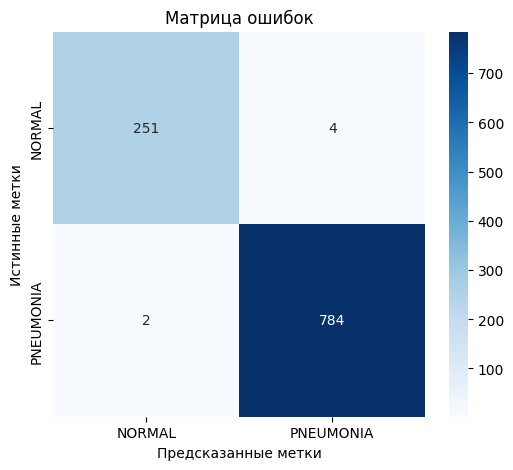

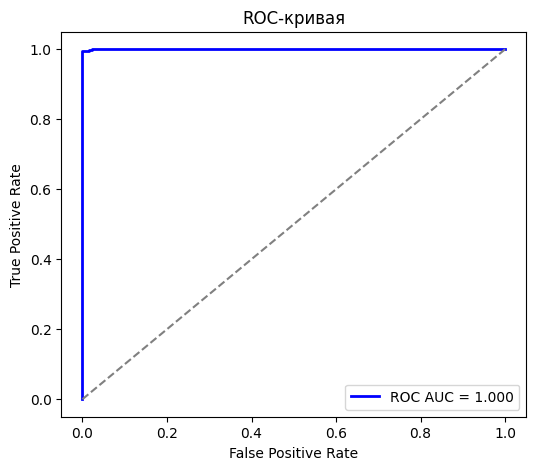

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

In [ ]:
model_metrics

[{'model_name': 'resnet_base',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_rotate',
  'metrics': {'Accuracy': 0.9827,
   'Precision': 0.9848,
   'Recall': 0.9924,
   'F1-score': 0.9886}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_color',
  'metrics': {'Accuracy': 0.9923,
   'Precision': 0.9949,
   'Recall': 0.9949,
   'F1-score': 0.9949}},
 {'model_name': 'resnet_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_blur',
  'metrics': {'Accuracy': 0.976,
   'Precision': 0.9947,
   'Recall': 0.9729,
   'F1-score': 0.9837}},
 {'model_name': 'resnet_base_color',
  'metrics': {'Accuracy': 0.9938,
   'Precision': 0.9994,
   'Recall': 0.9923,
   'F1-score': 0.9958}},
 {'model_name': 'resnet_base_blur_affine',

In [ ]:
model_metrics.append(
        {
            "model_name": "resnet_base_color_affine",
            "metrics": {
                "Accuracy": 0.9942,
            "Precision": 0.9949,
            "Recall": 0.9975,
            "F1-score": 0.9962
            }
        }
    )


Тестирование: 100%|██████████| 33/33 [00:04<00:00,  8.17it/s]

Отчет о классификации:
              precision    recall  f1-score   support

      NORMAL       0.99      0.98      0.99       255
   PNEUMONIA       0.99      1.00      1.00       786

    accuracy                           0.99      1041
   macro avg       0.99      0.99      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Accuracy: 0.9942
Матрица ошибок:
[[251   4]
 [  2 784]]


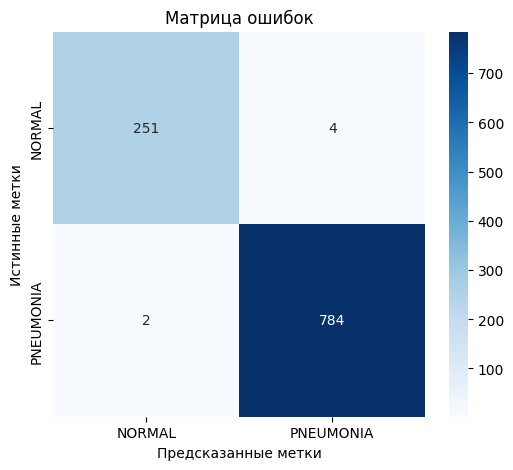

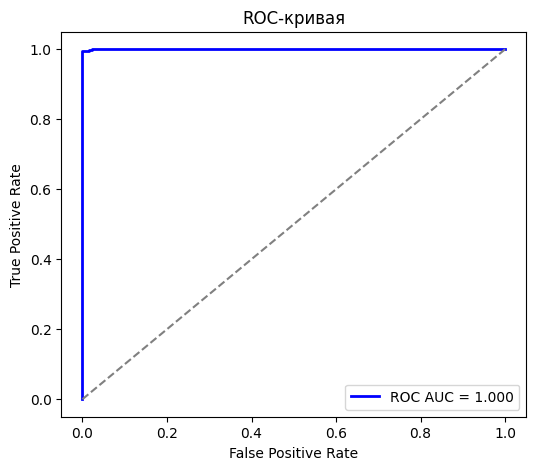

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model_old(model_resnet, val_loader_base)

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.46it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       1.00      0.98      0.99       255
   PNEUMONIA       0.99      1.00      1.00       786

    accuracy                           0.99      1041
   macro avg       0.99      0.99      0.99      1041
weighted avg       0.99      0.99      0.99      1041

Accuracy: 0.9933
Матрица ошибок:
[[249   6]
 [  1 785]]


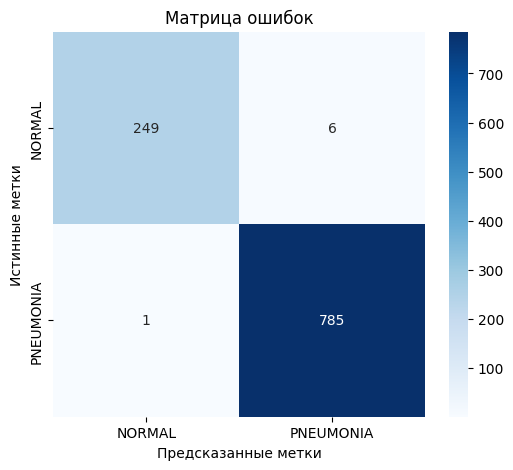

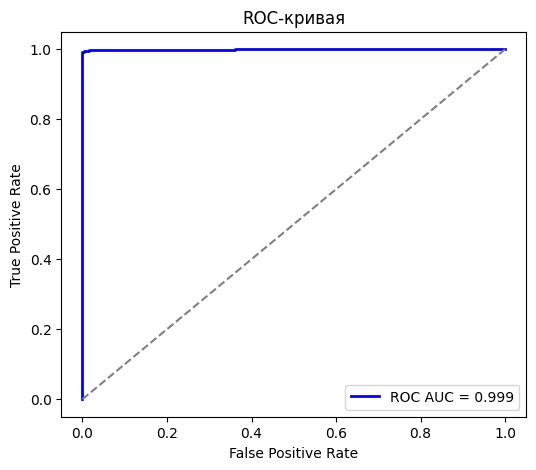

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base)

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.71it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       0.99      0.97      0.98       829
   PNEUMONIA       0.99      1.00      0.99      2294

    accuracy                           0.99      3123
   macro avg       0.99      0.98      0.99      3123
weighted avg       0.99      0.99      0.99      3123

Accuracy: 0.9901
Матрица ошибок:
[[ 803   26]
 [   5 2289]]


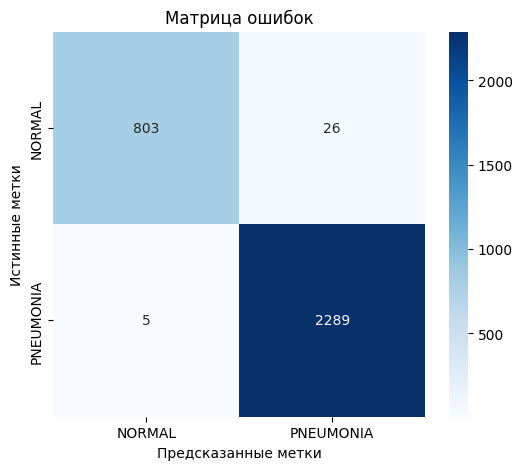

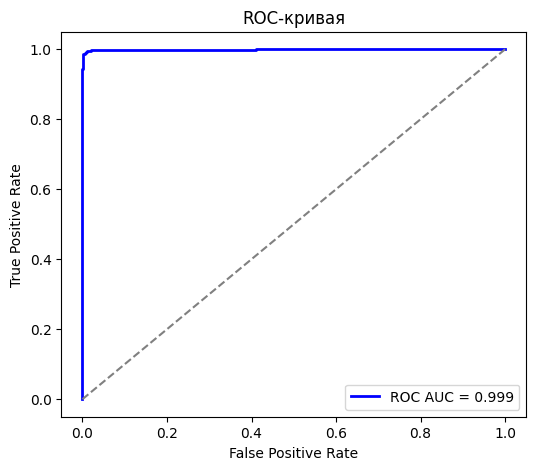

In [ ]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_base_color_affine.pth")

# Затем загружаем только веса модели
model_resnet.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet, val_loader_base_color_affine)

In [ ]:
# Добавляем результаты в словарь
models_accuracy['model_resnet_base_color_affine'] = 0.9933


# Выводим словарь
print("Результаты моделей:")
print(models_accuracy)

Результаты моделей:
{'model_resnet_base': 0.9827, 'model_resnet_rotate': 0.975, 'model_resnet_color': 0.9817, 'model_resnet_affine': 0.976, 'model_resnet_blur': 0.9885, 'model_resnet_base_blur': 0.9875, 'model_resnet_base_color': 0.9856, 'model_resnet_base_color_affine': 0.9933}


Тестирование: 100%|██████████| 20/20 [00:02<00:00,  7.89it/s]


Отчет о классификации:

              precision    recall  f1-score   support

      NORMAL       1.00      0.34      0.50       234
   PNEUMONIA       0.72      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.86      0.67      0.67       624
weighted avg       0.82      0.75      0.71       624

Accuracy: 0.7516
Матрица ошибок:
[[ 79 155]
 [  0 390]]


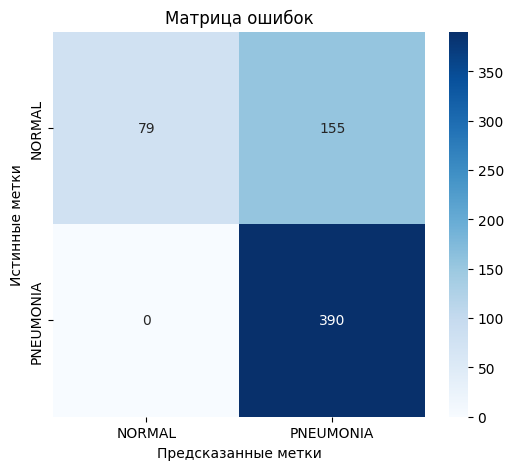

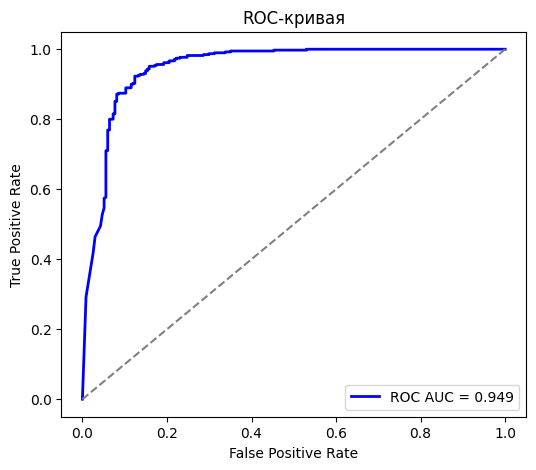

In [ ]:
evaluate_model(model_resnet, test_loader)

#Oversampling

In [31]:
from torch.utils.data import WeightedRandomSampler
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Функция для вычисления весов классов с улучшенной обработкой
def get_class_weights(dataset):
    # Получаем метки из датасета
    if hasattr(dataset, 'indices'):  # Если это Subset
        targets = torch.tensor(dataset.dataset.targets)[dataset.indices]
    else:  # Если это обычный Dataset
        targets = torch.tensor(dataset.targets)

    # Вычисляем количество элементов в каждом классе
    class_counts = torch.bincount(targets)
    print(f"Количество образцов по классам: {class_counts.tolist()}")

    # Вычисляем веса для каждого образца
    class_weights = 1. / class_counts.float()
    sample_weights = class_weights[targets]
    return sample_weights

# Получение весов для семплера
sample_weights = get_class_weights(train_data_base)

# Создание WeightedRandomSampler для oversampling
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),  # Можно увеличить для большего oversampling
    replacement=True
)

# Создание DataLoader с семплером
train_loader_oversampling = torch.utils.data.DataLoader(
    combined_train_data,
    batch_size=32,
    sampler=sampler,  # Используем наш семплер
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader_oversampling = torch.utils.data.DataLoader(
    combined_val_data,
    batch_size=32,
    sampler=sampler,  # Используем наш семплер
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

# Проверка балансировки после oversampling
def check_balance(loader):
    class_counts = torch.zeros(2)
    for _, labels in loader:
        class_counts += torch.bincount(labels, minlength=2)
    print(f"Баланс классов после oversampling: {class_counts.tolist()}")

check_balance(train_loader_oversampling)

# Инициализация модели
model_resnet_weighted = models.resnet18(pretrained=True)
model_resnet_weighted.fc = nn.Linear(model_resnet_weighted.fc.in_features, 2)
model_resnet_weighted = model_resnet_weighted.to(device)

# Функция потерь с весами классов (уже учтено в семплере, поэтому можно без весов)
criterion = nn.CrossEntropyLoss()  # Веса уже учтены в семплере

# Оптимизатор с настройкой learning rate
optimizer = optim.AdamW(model_resnet_weighted.parameters(), lr=0.001, weight_decay=1e-4)

# Планировщик learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Обучение модели с oversampling
train_model(
    model_resnet_weighted,
    train_loader_oversampling,
    val_loader_base_color_affine,
    criterion,
    optimizer,
    num_epochs=5,
    save_path="best_model_resnet_oversampling.pth"
)


Количество образцов по классам: [1093, 3072]
Баланс классов после oversampling: [2121.0, 2044.0]
Эпоха 1/5
----------


Тренировка: 100%|██████████| 131/131 [00:19<00:00,  6.69it/s]


Train loss: 0.1046, train accuracy: 96.1585


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.54it/s]


Val_loss: 0.0733, Val_accuracy: 97.5024
Модель сохранена с точностью 97.5024
Epoch  0  |  Time: 31.18s  |  Est. remaining: 0.00s
Train Loss: 0.104605  |  Val Loss: 0.073334
Train Accuracy: 96.16%  |  Val Accuracy: 97.50%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 131/131 [00:18<00:00,  7.03it/s]


Train loss: 0.0653, train accuracy: 97.3349


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.66it/s]


Val_loss: 0.0766, Val_accuracy: 96.9260
Epoch  1  |  Time: 29.96s  |  Est. remaining: 91.72s
Train Loss: 0.065297  |  Val Loss: 0.076587
Train Accuracy: 97.33%  |  Val Accuracy: 96.93%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 131/131 [00:19<00:00,  6.87it/s]


Train loss: 0.0271, train accuracy: 99.1357


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.72it/s]


Val_loss: 0.0472, Val_accuracy: 98.3990
Модель сохранена с точностью 98.3990
Epoch  2  |  Time: 30.42s  |  Est. remaining: 61.04s
Train Loss: 0.027077  |  Val Loss: 0.047216
Train Accuracy: 99.14%  |  Val Accuracy: 98.40%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 131/131 [00:18<00:00,  6.94it/s]


Train loss: 0.0153, train accuracy: 99.3037


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.52it/s]


Val_loss: 0.0907, Val_accuracy: 97.1502
Epoch  3  |  Time: 30.37s  |  Est. remaining: 30.48s
Train Loss: 0.015346  |  Val Loss: 0.090740
Train Accuracy: 99.30%  |  Val Accuracy: 97.15%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 131/131 [00:18<00:00,  6.92it/s]


Train loss: 0.0238, train accuracy: 99.4478


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.59it/s]

Val_loss: 0.1076, Val_accuracy: 97.3423
Epoch  4  |  Time: 30.33s  |  Est. remaining: 0.00s
Train Loss: 0.023781  |  Val Loss: 0.107597
Train Accuracy: 99.45%  |  Val Accuracy: 97.34%
--------------------------------------------------
Обучение завершено за 152.27 секунд
Среднее время эпохи: 30.45s
Лучшая точность на валидации: 98.3990


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

Тестирование: 100%|██████████| 33/33 [00:03<00:00,  8.59it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9846
Precision:      0.9923
Recall:         0.9873
F1-score:       0.9898

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9614    0.9765    0.9689       255
   PNEUMONIA     0.9923    0.9873    0.9898       786

    accuracy                         0.9846      1041
   macro avg     0.9769    0.9819    0.9793      1041
weighted avg     0.9847    0.9846    0.9847      1041


МАТРИЦА ОШИБОК:
[[249   6]
 [ 10 776]]


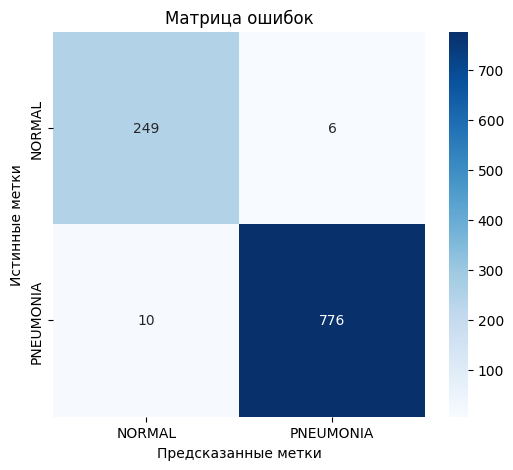

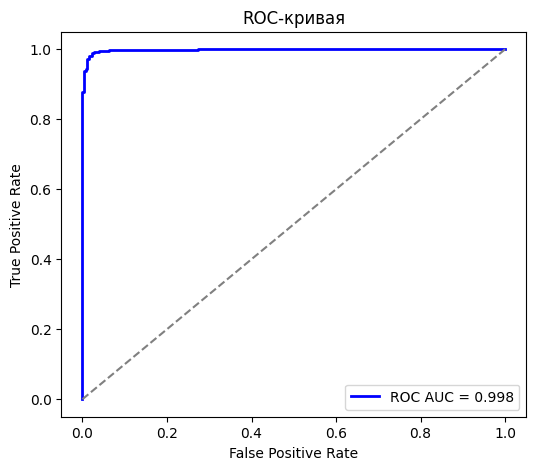

In [34]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_resnet_oversampling.pth")

# Затем загружаем только веса модели
model_resnet_weighted.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet_weighted, val_loader_base)

In [54]:
model_metrics = []

In [55]:
model_metrics.append(
        {
            "name": "oversampling",
            "metrics": {
                "Accuracy": 0.9846,
            "Precision": 0.9923,
            "Recall": 0.9873,
            "F1-score": 0.9898
            }
        }
    )

Тестирование: 100%|██████████| 20/20 [00:02<00:00,  7.61it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.7853
Precision:      0.7452
Recall:         0.9974
F1-score:       0.8531

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9902    0.4316    0.6012       234
   PNEUMONIA     0.7452    0.9974    0.8531       390

    accuracy                         0.7853       624
   macro avg     0.8677    0.7145    0.7271       624
weighted avg     0.8371    0.7853    0.7586       624


МАТРИЦА ОШИБОК:
[[101 133]
 [  1 389]]


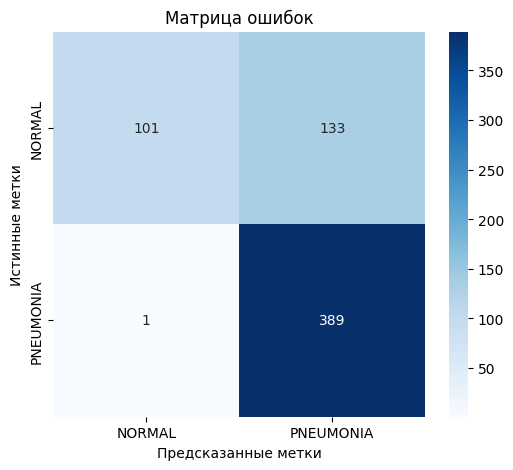

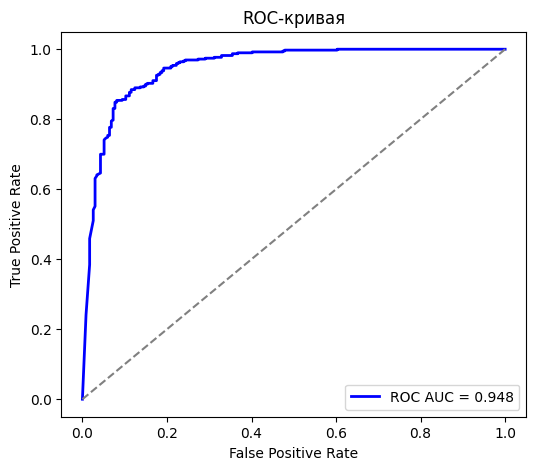

In [36]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_resnet_oversampling.pth")

# Затем загружаем только веса модели
model_resnet_weighted.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model_resnet_weighted, test_loader)

#Undersampling

In [28]:
def create_undersampler(dataset):
    # Получаем метки (адаптированный код из вашей функции)
    targets = []
    if isinstance(dataset, torch.utils.data.ConcatDataset):
        for sub_dataset in dataset.datasets:
            targets.extend([label for _, label in sub_dataset])
    else:
        targets = [label for _, label in dataset]

    targets = torch.tensor(targets)
    class_counts = torch.bincount(targets)
    print(f"Исходное распределение: {class_counts.tolist()}")

    # Находим размер меньшего класса
    min_count = min(class_counts).item()

    # Собираем индексы для каждого класса
    class_indices = [torch.where(targets == i)[0] for i in range(len(class_counts))]

    # Случайно выбираем min_count элементов из каждого класса
    undersampled_indices = []
    for indices in class_indices:
        undersampled_indices.append(indices[torch.randperm(len(indices))[:min_count]])

    undersampled_indices = torch.cat(undersampled_indices)

    # Создаем Subset сбалансированного датасета
    balanced_dataset = torch.utils.data.Subset(dataset, undersampled_indices)

    # Проверка баланса
    new_targets = targets[undersampled_indices]
    print(f"После undersampling: {torch.bincount(new_targets).tolist()}")

    return balanced_dataset

# Создаем сбалансированный датасет
balanced_train_data_under = create_undersampler(combined_train_data)

# DataLoader без семплера (данные уже сбалансированы)
train_loader = torch.utils.data.DataLoader(
    balanced_train_data_under,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

Исходное распределение: [3248, 9247]
После undersampling: [3248, 3248]


In [39]:
# Инициализация модели
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Функция потерь (без весов, так как undersampling уже балансирует)
criterion = nn.CrossEntropyLoss()

# Обучение (ВАЖНО: валидационный loader без изменений!)
train_model(
    model=model,
    train_loader=train_loader,
    test_loader=val_loader_base_color_affine,  # Оригинальный валидационный набор
    criterion=criterion,
    optimizer=optim.AdamW(model.parameters(), lr=0.001),
    num_epochs=5,
    save_path="best_model_undersampled.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 203/203 [00:30<00:00,  6.61it/s]


Train loss: 0.1040, train accuracy: 96.0129


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.38it/s]


Val_loss: 0.0763, Val_accuracy: 97.1822
Модель сохранена с точностью 97.1822
Epoch  0  |  Time: 42.52s  |  Est. remaining: 0.00s
Train Loss: 0.103990  |  Val Loss: 0.076271
Train Accuracy: 96.01%  |  Val Accuracy: 97.18%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 203/203 [00:30<00:00,  6.64it/s]


Train loss: 0.0512, train accuracy: 98.1373


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Val_loss: 0.0446, Val_accuracy: 98.1108
Модель сохранена с точностью 98.1108
Epoch  1  |  Time: 42.42s  |  Est. remaining: 127.40s
Train Loss: 0.051182  |  Val Loss: 0.044615
Train Accuracy: 98.14%  |  Val Accuracy: 98.11%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 203/203 [00:30<00:00,  6.65it/s]


Train loss: 0.0460, train accuracy: 98.5530


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.41it/s]


Val_loss: 0.0386, Val_accuracy: 98.8473
Модель сохранена с точностью 98.8473
Epoch  2  |  Time: 42.29s  |  Est. remaining: 84.81s
Train Loss: 0.045988  |  Val Loss: 0.038624
Train Accuracy: 98.55%  |  Val Accuracy: 98.85%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 203/203 [00:29<00:00,  6.77it/s]


Train loss: 0.0340, train accuracy: 98.8300


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Val_loss: 0.0508, Val_accuracy: 98.3349
Epoch  3  |  Time: 41.70s  |  Est. remaining: 42.23s
Train Loss: 0.033997  |  Val Loss: 0.050817
Train Accuracy: 98.83%  |  Val Accuracy: 98.33%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 203/203 [00:30<00:00,  6.55it/s]


Train loss: 0.0243, train accuracy: 99.1687


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.41it/s]

Val_loss: 0.0898, Val_accuracy: 96.9260
Epoch  4  |  Time: 42.64s  |  Est. remaining: 0.00s
Train Loss: 0.024258  |  Val Loss: 0.089782
Train Accuracy: 99.17%  |  Val Accuracy: 96.93%
--------------------------------------------------
Обучение завершено за 211.57 секунд
Среднее время эпохи: 42.31s
Лучшая точность на валидации: 98.8473


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s]


ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9875
Precision:      0.9923
Recall:         0.9910
F1-score:       0.9916

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9737    0.9774    0.9755       796
   PNEUMONIA     0.9923    0.9910    0.9916      2327

    accuracy                         0.9875      3123
   macro avg     0.9830    0.9842    0.9836      3123
weighted avg     0.9875    0.9875    0.9875      3123


МАТРИЦА ОШИБОК:
[[ 778   18]
 [  21 2306]]


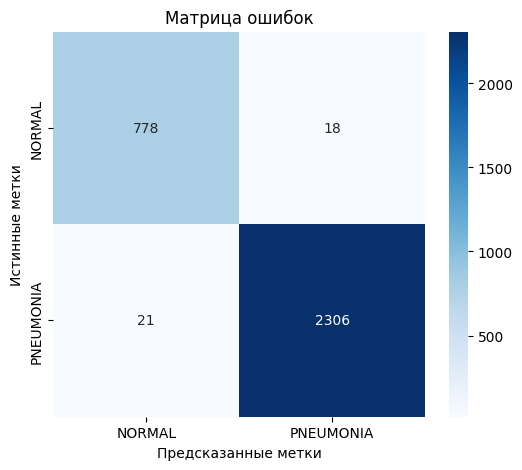

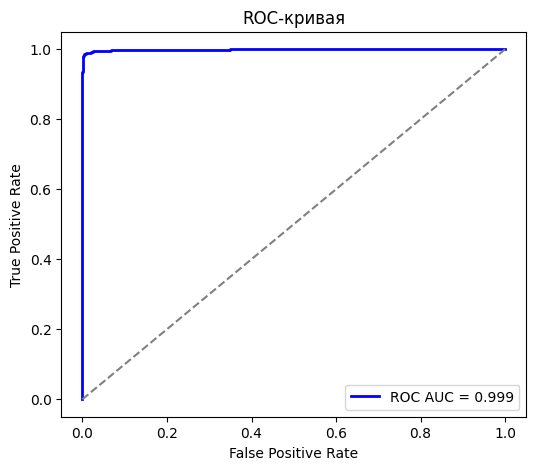

In [40]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_undersampled.pth")

# Затем загружаем только веса модели
model.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model, val_loader_base_color_affine)

In [56]:
model_metrics.append(
        {
            "name": "undersampling",
            "metrics": {
                "Accuracy": 0.9875,
            "Precision": 0.9923,
            "Recall": 0.9910,
            "F1-score": 0.9916
            }
        }
    )

# Взвешивание классов

In [41]:
def get_class_weights(dataset):
    """Корректное вычисление весов классов для несбалансированных данных"""
    # Получаем метки из датасета (универсальный способ)
    if isinstance(dataset, torch.utils.data.Subset):
        # Для Subset получаем метки из оригинального датасета по индексам
        targets = []
        for i in dataset.indices:
            _, label = dataset.dataset[i]  # Получаем метку из оригинального датасета
            targets.append(label)
        targets = torch.tensor(targets)
    elif isinstance(dataset, torch.utils.data.ConcatDataset):
        # Для объединенных датасетов собираем все метки
        targets = []
        for sub_dataset in dataset.datasets:
            for i in range(len(sub_dataset)):
                _, label = sub_dataset[i]
                targets.append(label)
        targets = torch.tensor(targets)
    elif hasattr(dataset, 'targets'):
        targets = torch.tensor(dataset.targets)
    else:
        # Общий случай - итерируем по датасету
        targets = []
        for _, label in dataset:
            targets.append(label)
        targets = torch.tensor(targets)

    # Вычисляем количество элементов в каждом классе
    class_counts = torch.bincount(targets)
    print(f"Распределение классов: {class_counts.tolist()}")

    # Вычисляем веса классов (обратная частота с нормализацией)
    class_weights = 1. / class_counts.float()
    class_weights = class_weights / class_weights.sum()  # Нормализация
    return class_weights

# Получаем веса классов
class_weights = get_class_weights(combined_train_data)
print(f"Веса классов: {class_weights.tolist()}")

# Создаем веса для каждого образца (используем ту же логику, что и в get_class_weights)
if isinstance(combined_train_data, torch.utils.data.Subset):
    targets = []
    for i in combined_train_data.indices:
        _, label = combined_train_data.dataset[i]
        targets.append(label)
    targets = torch.tensor(targets)
else:
    targets = torch.tensor([label for _, label in combined_train_data])

sample_weights = class_weights[targets]

# Остальной код остается без изменений
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader_balanced = torch.utils.data.DataLoader(
    combined_train_data,
    batch_size=32,
    sampler=sampler,
    num_workers=4,
    worker_init_fn=seed_worker,
    generator=g
)

Распределение классов: [3248, 9247]
Веса классов: [0.740056037902832, 0.25994399189949036]


In [42]:
# Инициализация модели
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# Функция потерь (без весов, так как undersampling уже балансирует)
criterion = nn.CrossEntropyLoss()

# Обучение (ВАЖНО: валидационный loader без изменений!)
train_model(
    model=model,
    train_loader=train_loader_balanced,
    test_loader=val_loader_base_color_affine,  # Оригинальный валидационный набор
    criterion=criterion,
    optimizer=optim.AdamW(model.parameters(), lr=0.001),
    num_epochs=5,
    save_path="best_model_balanced.pth"
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:58<00:00,  6.72it/s]


Train loss: 0.0843, train accuracy: 97.1188


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


Val_loss: 0.0819, Val_accuracy: 97.3743
Модель сохранена с точностью 97.3743
Epoch  0  |  Time: 70.01s  |  Est. remaining: 0.00s
Train Loss: 0.084291  |  Val Loss: 0.081927
Train Accuracy: 97.12%  |  Val Accuracy: 97.37%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:58<00:00,  6.66it/s]


Train loss: 0.0338, train accuracy: 98.7675


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.39it/s]


Val_loss: 0.0568, Val_accuracy: 98.0468
Модель сохранена с точностью 98.0468
Epoch  1  |  Time: 70.48s  |  Est. remaining: 210.74s
Train Loss: 0.033757  |  Val Loss: 0.056805
Train Accuracy: 98.77%  |  Val Accuracy: 98.05%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:57<00:00,  6.74it/s]


Train loss: 0.0271, train accuracy: 99.1357


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.24it/s]


Val_loss: 0.0409, Val_accuracy: 98.3029
Модель сохранена с точностью 98.3029
Epoch  2  |  Time: 69.99s  |  Est. remaining: 140.32s
Train Loss: 0.027089  |  Val Loss: 0.040918
Train Accuracy: 99.14%  |  Val Accuracy: 98.30%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:58<00:00,  6.71it/s]


Train loss: 0.0237, train accuracy: 99.2397


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Val_loss: 0.0782, Val_accuracy: 97.5664
Epoch  3  |  Time: 70.11s  |  Est. remaining: 70.15s
Train Loss: 0.023742  |  Val Loss: 0.078203
Train Accuracy: 99.24%  |  Val Accuracy: 97.57%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:57<00:00,  6.80it/s]


Train loss: 0.0169, train accuracy: 99.4398


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]

Val_loss: 0.0657, Val_accuracy: 97.9187
Epoch  4  |  Time: 69.24s  |  Est. remaining: 0.00s
Train Loss: 0.016920  |  Val Loss: 0.065734
Train Accuracy: 99.44%  |  Val Accuracy: 97.92%
--------------------------------------------------
Обучение завершено за 349.84 секунд
Среднее время эпохи: 69.97s
Лучшая точность на валидации: 98.3029


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.42it/s]



ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9840
Precision:      0.9818
Recall:         0.9970
F1-score:       0.9893

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9908    0.9460    0.9679       796
   PNEUMONIA     0.9818    0.9970    0.9893      2327

    accuracy                         0.9840      3123
   macro avg     0.9863    0.9715    0.9786      3123
weighted avg     0.9841    0.9840    0.9839      3123


МАТРИЦА ОШИБОК:
[[ 753   43]
 [   7 2320]]


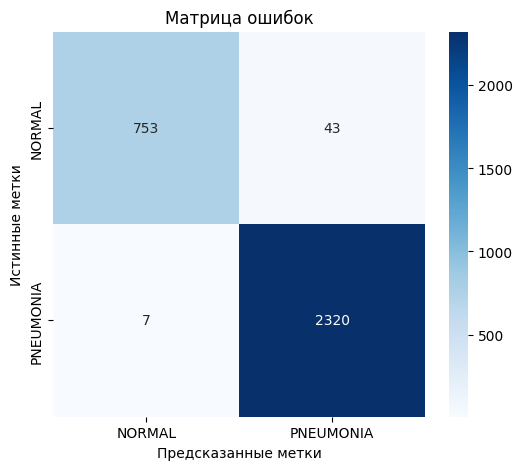

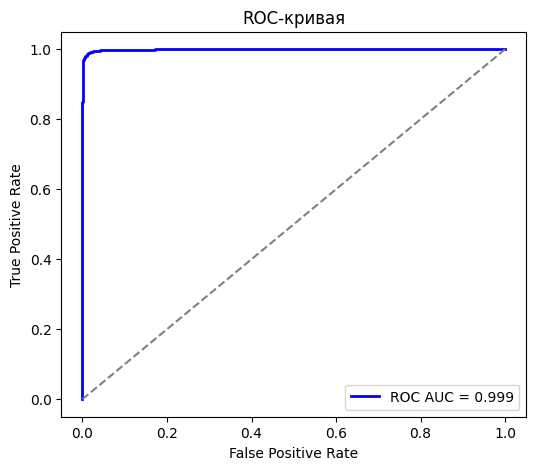

In [43]:
# Загрузка полного чекпоинта
checkpoint = torch.load("best_model_balanced.pth")

# Затем загружаем только веса модели
model.load_state_dict(checkpoint)

# Оценка модели
evaluate_model(model, val_loader_base_color_affine)

In [57]:
model_metrics.append(
        {
            "name": "balanced",
            "metrics": {
                "Accuracy": 0.9840,
            "Precision": 0.9818,
            "Recall": 0.9970,
            "F1-score": 0.9893
            }
        }
    )

# FocalLoss

In [45]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss для несбалансированных классов.

        Args:
            alpha (Tensor, optional): Веса классов. Size [num_classes].
            gamma (float): Параметр фокусировки (gamma >= 0).
            reduction (str): Способ агрегации ('none', 'mean', 'sum').
        """
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # Вычисляем log-softmax
        log_pt = F.log_softmax(inputs, dim=1)
        pt = torch.exp(log_pt)

        # Получаем вероятности для правильных классов
        pt = pt.gather(1, targets.view(-1, 1)).squeeze()
        log_pt = log_pt.gather(1, targets.view(-1, 1)).squeeze()

        # Вычисляем focal loss компонент
        focal_loss = - (1 - pt) ** self.gamma * log_pt

        # Применяем веса классов
        if self.alpha is not None:
            alpha = self.alpha.to(inputs.device)
            focal_loss = alpha[targets] * focal_loss

        # Агрегируем потери
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [50]:
import torch.nn.functional as F
from functools import partial
# Загрузка предобученной модели ResNet18
model_resnet_fl = models.resnet18(pretrained=True)

# Замена последнего слоя на новый (2 класса: кошки и собаки)
num_ftrs = model_resnet_fl.fc.in_features
model_resnet_fl.fc = nn.Linear(num_ftrs, 2)

# Перемещение модели на устройство (GPU или CPU)
model_resnet_fl = model_resnet_fl.to(device)


# Получаем веса классов
class_weights = get_class_weights(combined_train_data)  # Ваша функция
class_weights = class_weights.to(device)

# Инициализация Focal Loss
criterion = FocalLoss(alpha=class_weights, gamma=2.0)  # Только здесь задаём alpha!

# Обучение (передаём только model, loader и criterion)
train_model(
    model=model_resnet_fl,
    train_loader=train_loader_base_color_affine,
    test_loader=val_loader_base_color_affine,
    criterion=criterion,  # Уже содержит alpha
    optimizer=optim.Adam(model_resnet_fl.parameters(), lr=0.001),
    num_epochs=5,
    save_path="best_model_focal_loss.pth"
)


Распределение классов: [3248, 9247]
Эпоха 1/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.65it/s]


Train loss: 0.0151, train accuracy: 96.3745


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.35it/s]


Val_loss: 0.0087, Val_accuracy: 94.7807
Модель сохранена с точностью 94.7807
Epoch  0  |  Time: 57.00s  |  Est. remaining: 0.00s
Train Loss: 0.015134  |  Val Loss: 0.008742
Train Accuracy: 96.37%  |  Val Accuracy: 94.78%
Эпоха 2/5
----------


Тренировка: 100%|██████████| 391/391 [00:46<00:00,  8.45it/s]


Train loss: 0.0053, train accuracy: 98.0392


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.37it/s]


Val_loss: 0.0164, Val_accuracy: 93.8200
Epoch  1  |  Time: 57.97s  |  Est. remaining: 172.46s
Train Loss: 0.005306  |  Val Loss: 0.016402
Train Accuracy: 98.04%  |  Val Accuracy: 93.82%
Эпоха 3/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.66it/s]


Train loss: 0.0060, train accuracy: 97.9032


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.36it/s]


Val_loss: 0.0043, Val_accuracy: 98.3349
Модель сохранена с точностью 98.3349
Epoch  2  |  Time: 56.98s  |  Est. remaining: 114.64s
Train Loss: 0.006037  |  Val Loss: 0.004273
Train Accuracy: 97.90%  |  Val Accuracy: 98.33%
Эпоха 4/5
----------


Тренировка: 100%|██████████| 391/391 [00:46<00:00,  8.40it/s]


Train loss: 0.0045, train accuracy: 98.3353


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.31it/s]


Val_loss: 0.0054, Val_accuracy: 98.1428
Epoch  3  |  Time: 58.35s  |  Est. remaining: 57.58s
Train Loss: 0.004486  |  Val Loss: 0.005393
Train Accuracy: 98.34%  |  Val Accuracy: 98.14%
Эпоха 5/5
----------


Тренировка: 100%|██████████| 391/391 [00:45<00:00,  8.50it/s]


Train loss: 0.0033, train accuracy: 98.9276


Валидация: 100%|██████████| 98/98 [00:11<00:00,  8.30it/s]

Val_loss: 0.0030, Val_accuracy: 98.3670
Модель сохранена с точностью 98.3670
Epoch  4  |  Time: 57.89s  |  Est. remaining: 0.00s
Train Loss: 0.003294  |  Val Loss: 0.002967
Train Accuracy: 98.93%  |  Val Accuracy: 98.37%
--------------------------------------------------
Обучение завершено за 288.20 секунд
Среднее время эпохи: 57.64s
Лучшая точность на валидации: 98.3670


(ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [51]:
# Загрузка лучшей модели
model_resnet_fl.load_state_dict(torch.load("best_model_focal_loss.pth"))

<All keys matched successfully>

Тестирование: 100%|██████████| 98/98 [00:11<00:00,  8.20it/s]


ИТОГОВЫЕ МЕТРИКИ КЛАССИФИКАЦИИ:
Accuracy:       0.9840
Precision:      0.9991
Recall:         0.9794
F1-score:       0.9891

ДЕТАЛЬНЫЙ ОТЧЕТ О КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

      NORMAL     0.9430    0.9975    0.9695       796
   PNEUMONIA     0.9991    0.9794    0.9891      2327

    accuracy                         0.9840      3123
   macro avg     0.9711    0.9884    0.9793      3123
weighted avg     0.9848    0.9840    0.9841      3123


МАТРИЦА ОШИБОК:
[[ 794    2]
 [  48 2279]]


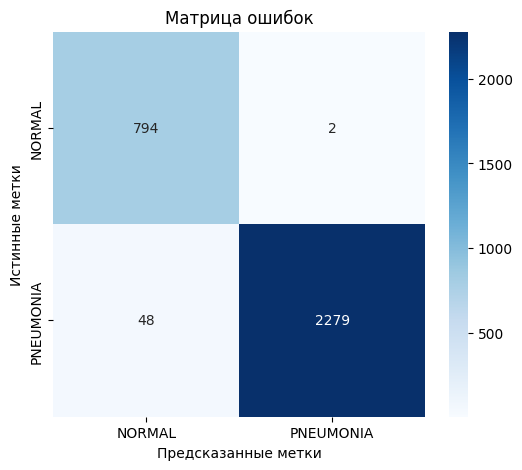

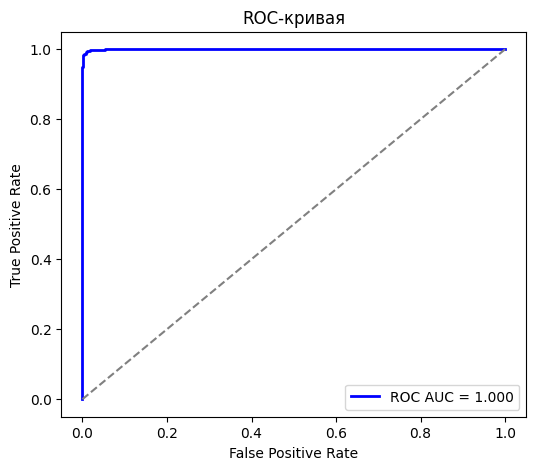

In [53]:
# Оценка модели
evaluate_model(model_resnet_fl, val_loader_base_color_affine)

In [58]:
model_metrics.append(
        {
            "name": "focal_loss",
            "metrics": {
                "Accuracy": 0.9840,
            "Precision": 0.9991,
            "Recall": 0.9794,
            "F1-score": 0.9891
            }
        }
    )

#Сравнение подходов

In [64]:
model_metrics[1]['name']='undersampling'

In [65]:
model_metrics

[{'name': 'oversampling',
  'metrics': {'Accuracy': 0.9846,
   'Precision': 0.9923,
   'Recall': 0.9873,
   'F1-score': 0.9898}},
 {'name': 'undersampling',
  'metrics': {'Accuracy': 0.9875,
   'Precision': 0.9923,
   'Recall': 0.991,
   'F1-score': 0.9916}},
 {'name': 'balanced',
  'metrics': {'Accuracy': 0.984,
   'Precision': 0.9818,
   'Recall': 0.997,
   'F1-score': 0.9893}},
 {'name': 'focal_loss',
  'metrics': {'Accuracy': 0.984,
   'Precision': 0.9991,
   'Recall': 0.9794,
   'F1-score': 0.9891}}]

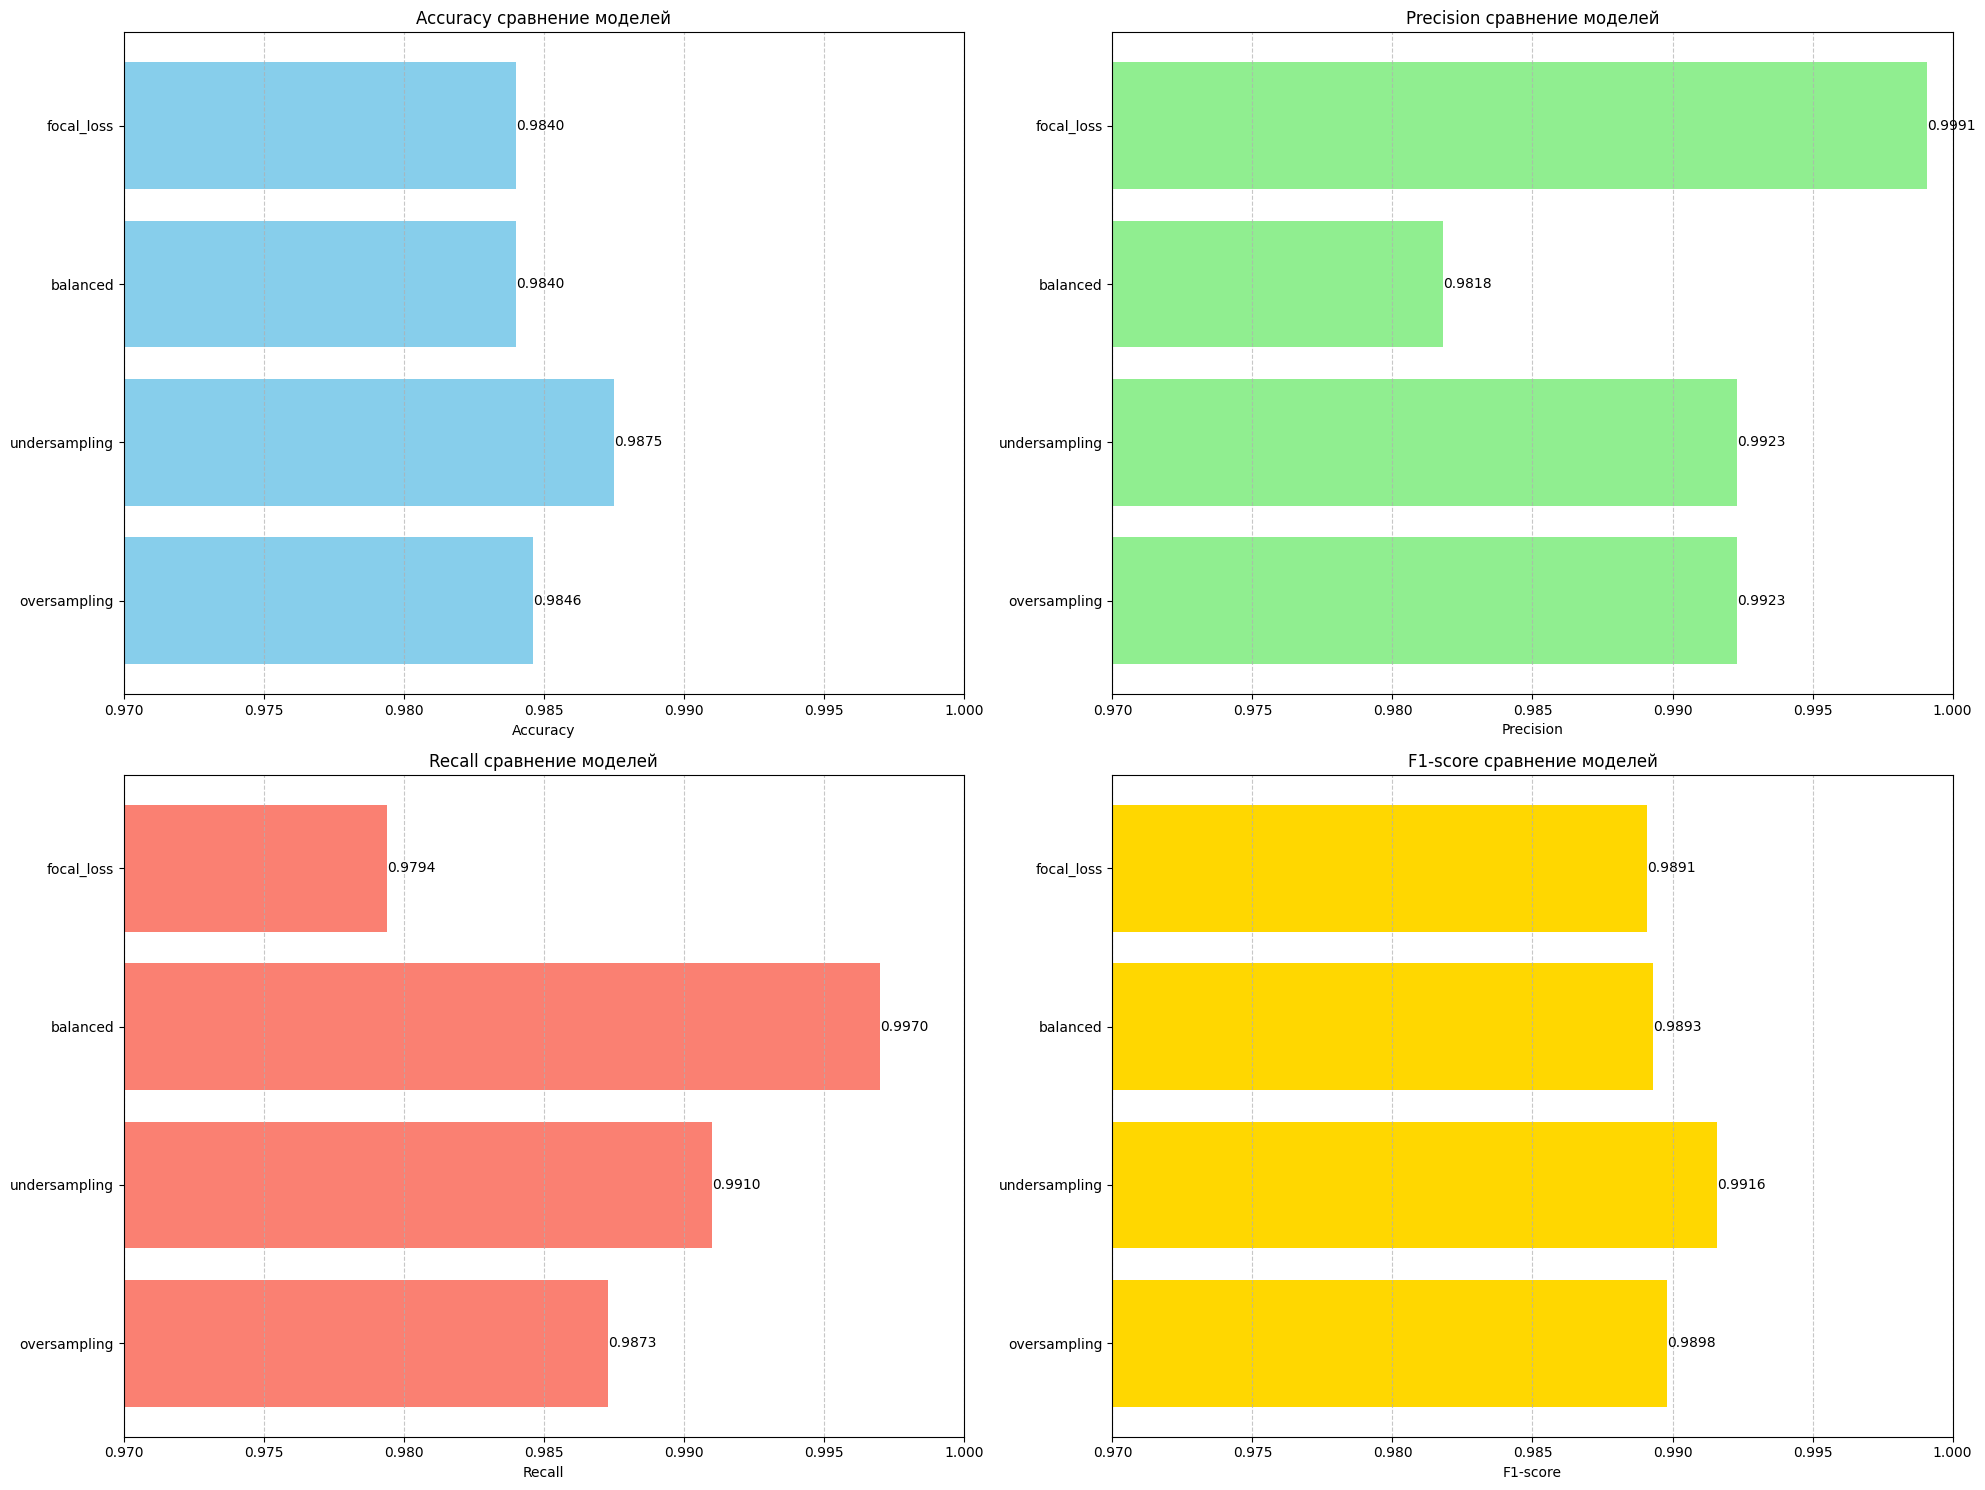

In [66]:
import matplotlib.pyplot as plt
import numpy as np

# Извлекаем названия моделей и метрики
model_names = [m['name'] for m in model_metrics]
accuracy = [m['metrics']['Accuracy'] for m in model_metrics]
precision = [m['metrics']['Precision'] for m in model_metrics]
recall = [m['metrics']['Recall'] for m in model_metrics]
f1 = [m['metrics']['F1-score'] for m in model_metrics]

# Создаем фигуру с 4 подграфиками
plt.figure(figsize=(20, 15))

# График Accuracy
plt.subplot(2, 2, 1)
bars = plt.barh(model_names, accuracy, color='skyblue')
plt.xlim(0.97, 1.0)
plt.title('Accuracy сравнение моделей')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
# Добавляем значения на столбцы
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График Precision
plt.subplot(2, 2, 2)
bars = plt.barh(model_names, precision, color='lightgreen')
plt.xlim(0.97, 1.0)
plt.title('Precision сравнение моделей')
plt.xlabel('Precision')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График Recall
plt.subplot(2, 2, 3)
bars = plt.barh(model_names, recall, color='salmon')
plt.xlim(0.97, 1.0)
plt.title('Recall сравнение моделей')
plt.xlabel('Recall')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

# График F1-score
plt.subplot(2, 2, 4)
bars = plt.barh(model_names, f1, color='gold')
plt.xlim(0.97, 1.0)
plt.title('F1-score сравнение моделей')
plt.xlabel('F1-score')
plt.grid(axis='x', linestyle='--', alpha=0.7)
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width:.4f}',
             ha='left', va='center')

plt.tight_layout()
plt.show()